In [1]:
import time

import numpy as np
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow

import lib.config.config as cfg
from lib.datasets import roidb as rdl_roidb
from lib.datasets.factory import get_imdb
from lib.datasets.imdb import imdb as imdb2
from lib.layer_utils.roi_data_layer import RoIDataLayer
from lib.nets.vgg16noise import vgg16
from lib.utils.timer import Timer

tf.app.flags.DEFINE_string('f', '', 'kernel')
try:
    import cPickle as pickle
except ImportError:
    import pickle
import os


def get_training_roidb(imdb):
    """Returns a roidb (Region of Interest database) for use in training."""
    if True:
        print('Appending horizontally-flipped training examples...')
        imdb.append_flipped_images()
        print('done')

    print('Preparing training data...')
    rdl_roidb.prepare_roidb(imdb)
    print('done')

    return imdb.roidb


def combined_roidb(imdb_names):
    """
    Combine multiple roidbs
    """

    def get_roidb(imdb_name):
        imdb = get_imdb(imdb_name)
        print('Loaded dataset `{:s}` for training'.format(imdb.name))
        imdb.set_proposal_method("gt")
        print('Set proposal method: {:s}'.format("gt"))
        roidb = get_training_roidb(imdb)
        return roidb

    roidbs = [get_roidb(s) for s in imdb_names.split('+')]
    roidb = roidbs[0]
    if len(roidbs) > 1:
        for r in roidbs[1:]:
            roidb.extend(r)
        tmp = get_imdb(imdb_names.split('+')[1])
        imdb = imdb2(imdb_names, tmp.classes)
    else:
        imdb = get_imdb(imdb_names)
    return imdb, roidb


class Train:
    def __init__(self):

        # Create network
        if cfg.FLAGS.net == 'vgg16':
            self.net = vgg16(batch_size=cfg.FLAGS.ims_per_batch)
        else:
            raise NotImplementedError

        self.imdb, self.roidb = combined_roidb("DIY_dataset")

        self.data_layer = RoIDataLayer(self.roidb, self.imdb.num_classes)
        self.output_dir = cfg.get_output_dir(self.imdb, 'default')

    def train(self):

        # Create session
        tfconfig = tf.ConfigProto(allow_soft_placement=True)  # allow_soft_placement = true : select GPU automatically
        tfconfig.gpu_options.allow_growth = True
        # tfconfig.gpu_options.per_process_gpu_memory_fraction = 0.90
        sess = tf.Session(config=tfconfig)

        with sess.graph.as_default():

            tf.set_random_seed(cfg.FLAGS.rng_seed)
            layers = self.net.create_architecture(sess, "TRAIN", self.imdb.num_classes, tag='default')
            loss = layers['total_loss']
            lr = tf.Variable(cfg.FLAGS.learning_rate, trainable=False)
            momentum = cfg.FLAGS.momentum
            optimizer = tf.train.MomentumOptimizer(lr, momentum)

            gvs = optimizer.compute_gradients(loss)

            # Double bias
            # Double the gradient of the bias if set
            if cfg.FLAGS.double_bias:
                final_gvs = []
                with tf.variable_scope('Gradient_Mult'):
                    for grad, var in gvs:
                        scale = 1.
                        if cfg.FLAGS.double_bias and '/biases:' in var.name:
                            scale *= 2.
                        if not np.allclose(scale, 1.0):
                            grad = tf.multiply(grad, scale)
                        final_gvs.append((grad, var))
                train_op = optimizer.apply_gradients(final_gvs)
            else:
                train_op = optimizer.apply_gradients(gvs)

            # We will handle the snapshots ourselves
            self.saver = tf.train.Saver(max_to_keep=100000)
            # Write the train and validation information to tensorboard
            writer = tf.summary.FileWriter('default/', sess.graph)
            # valwriter = tf.summary.FileWriter(self.tbvaldir)

        # Load weights
        # Fresh train directly from ImageNet weights
        print('Loading initial model weights from {:s}'.format(cfg.FLAGS.pretrained_model))
        variables = tf.global_variables()
        # Initialize all variables first
        sess.run(tf.variables_initializer(variables, name='init'))
        var_keep_dic = self.get_variables_in_checkpoint_file(cfg.FLAGS.pretrained_model)
        # Get the variables to restore, ignorizing the variables to fix
        variables_to_restore = self.net.get_variables_to_restore(variables, var_keep_dic, sess,
                                                                 cfg.FLAGS.pretrained_model)

        restorer = tf.train.Saver(variables_to_restore)
        restorer.restore(sess, cfg.FLAGS.pretrained_model)
        print('Loaded.')
        # Need to fix the variables before loading, so that the RGB weights are changed to BGR
        # For VGG16 it also changes the convolutional weights fc6 and fc7 to
        # fully connected weights
        self.net.fix_variables(sess, cfg.FLAGS.pretrained_model)
        print('Fixed.')
        sess.run(tf.assign(lr, cfg.FLAGS.learning_rate))
        last_snapshot_iter = 0

        timer = Timer()
        iter = last_snapshot_iter + 1
        last_summary_time = time.time()
        print('START TRAINING: ...')
        while iter < cfg.FLAGS.max_iters + 1:
            # Learning rate
            if iter == cfg.FLAGS.step_size + 1:
                # Add snapshot here before reducing the learning rate
                # self.snapshot(sess, iter)
                sess.run(tf.assign(lr, cfg.FLAGS.learning_rate * cfg.FLAGS.gamma))

            timer.tic()
            # Get training data, one batch at a time
            blobs = self.data_layer.forward()
            iter += 1
            # Compute the graph without summary
            if iter % 100 == 0:
                rpn_loss_cls, rpn_loss_box, loss_cls, loss_box, total_loss, summary = self.net.train_step_with_summary(
                    sess, blobs, train_op)
                timer.toc()

                run_metadata = tf.RunMetadata()
                writer.add_run_metadata(run_metadata, 'step%03d' % iter)
                writer.add_summary(summary, iter)
            else:
                rpn_loss_cls, rpn_loss_box, loss_cls, loss_box, total_loss = self.net.train_step(
                    sess, blobs, train_op)
                timer.toc()

            # Display training information
            if iter % (cfg.FLAGS.display) == 0:
                print('iter: %d / %d, total loss: %.6f\n >>> rpn_loss_cls: %.6f\n '
                      '>>> rpn_loss_box: %.6f\n >>> loss_cls: %.6f\n >>> loss_box: %.6f\n ' % \
                      (iter, cfg.FLAGS.max_iters, total_loss, rpn_loss_cls, rpn_loss_box, loss_cls, loss_box))
                print('speed: {:.3f}s / iter'.format(timer.average_time))

            if iter % cfg.FLAGS.snapshot_iterations == 0:
                self.snapshot(sess, iter)

    def get_variables_in_checkpoint_file(self, file_name):
        try:
            reader = pywrap_tensorflow.NewCheckpointReader(file_name)
            var_to_shape_map = reader.get_variable_to_shape_map()
            return var_to_shape_map
        except Exception as e:  # pylint: disable=broad-except
            print(str(e))
            if "corrupted compressed block contents" in str(e):
                print("It's likely that your checkpoint file has been compressed "
                      "with SNAPPY.")

    def snapshot(self, sess, iter):
        net = self.net

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        # Store the model snapshot
        filename = 'vgg16_faster_rcnn_noise_iter_{:d}'.format(iter) + '.ckpt'
        filename = os.path.join(self.output_dir, filename)
        self.saver.save(sess, filename)
        print('Wrote snapshot to: {:s}'.format(filename))

        # Also store some meta information, random state, etc.
        nfilename = 'vgg16_faster_rcnn_iter_{:d}'.format(iter) + '.pkl'
        nfilename = os.path.join(self.output_dir, nfilename)
        # current state of numpy random
        st0 = np.random.get_state()
        # current position in the database
        cur = self.data_layer._cur
        # current shuffled indeces of the database
        perm = self.data_layer._perm

        # Dump the meta info
        with open(nfilename, 'wb') as fid:
            pickle.dump(st0, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(cur, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(perm, fid, pickle.HIGHEST_PROTOCOL)
            pickle.dump(iter, fid, pickle.HIGHEST_PROTOCOL)

        return filename, nfilename


if __name__ == '__main__':
    train = Train()
    train.train()


Loaded dataset `DIY_dataset` for training
Set proposal method: gt
Appending horizontally-flipped training examples...
DIY_dataset gt roidb loaded from /home/jovyan/TensorRGBNet/Image_manipulation_detection-master/data/cache/DIY_dataset_gt_roidb.pkl
done
Preparing training data...
done


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loading initial model weights from ./data/imagenet_weights/vgg16.ckpt
Variables restored: vgg_16/conv1/conv1_1/biases:0
Variables restored: vgg_16/conv1/conv1_2/weights:0
Variables restored: vgg_16/conv1/conv1_2/biases:0
Variables restored: vgg_16/conv2/conv2_1/weights:0
Variables restored: vgg_16/conv2/conv2_1/biases:0
Variables restored: vgg_16/conv2/conv2_2/weights:0
Variables restored: vgg_16/conv2/conv2_2/biases:0
Variables restored: vgg_16/conv3/conv3_1/weights:0
Variables restored: vgg_16/conv3/conv3_1/biases:0
Variables restored: vgg_16/conv3/conv3_2/weights:0
Variables restored: vgg_16/conv3/conv3_2/biases:0
Variables restored: vgg_16/conv3/conv3_3/weights:0
Variables restored: vgg_16/conv3/conv3_3/biases:0
Variables restored: vgg_16/conv4/conv4_1/weights:0
Variables restored: vgg_16/conv4/conv4_1/biases:0
Variables restored: vgg_16/conv4/conv4_2/weights:0
Variables restored: vgg_16/conv4/conv4_2/biases:0
Variables restored: vgg_16/conv4/conv4_3/weights:0
Variables restored: v

iter: 380 / 1000, total loss: 0.378139
 >>> rpn_loss_cls: 0.241637
 >>> rpn_loss_box: 0.028370
 >>> loss_cls: 0.044075
 >>> loss_box: 0.064058
 
speed: 8.117s / iter
iter: 390 / 1000, total loss: 0.156403
 >>> rpn_loss_cls: 0.054887
 >>> rpn_loss_box: 0.009544
 >>> loss_cls: 0.091971
 >>> loss_box: 0.000000
 
speed: 8.105s / iter
iter: 400 / 1000, total loss: 0.751541
 >>> rpn_loss_cls: 0.106713
 >>> rpn_loss_box: 0.015357
 >>> loss_cls: 0.301897
 >>> loss_box: 0.327574
 
speed: 8.084s / iter
Wrote snapshot to: /home/jovyan/TensorRGBNet/Image_manipulation_detection-master/default/DIY_dataset/default/vgg16_faster_rcnn_noise_iter_400.ckpt
iter: 410 / 1000, total loss: 0.646398
 >>> rpn_loss_cls: 0.254288
 >>> rpn_loss_box: 0.038331
 >>> loss_cls: 0.175985
 >>> loss_box: 0.177793
 
speed: 8.077s / iter
iter: 420 / 1000, total loss: 0.849946
 >>> rpn_loss_cls: 0.062079
 >>> rpn_loss_box: 0.014536
 >>> loss_cls: 0.353327
 >>> loss_box: 0.420004
 
speed: 8.062s / iter
iter: 430 / 1000, total

iter: 830 / 1000, total loss: 0.383940
 >>> rpn_loss_cls: 0.022357
 >>> rpn_loss_box: 0.003065
 >>> loss_cls: 0.183353
 >>> loss_box: 0.175165
 
speed: 7.769s / iter
iter: 840 / 1000, total loss: 0.626004
 >>> rpn_loss_cls: 0.192204
 >>> rpn_loss_box: 0.031167
 >>> loss_cls: 0.181176
 >>> loss_box: 0.221457
 
speed: 7.763s / iter
iter: 850 / 1000, total loss: 0.326717
 >>> rpn_loss_cls: 0.098726
 >>> rpn_loss_box: 0.010079
 >>> loss_cls: 0.122471
 >>> loss_box: 0.095441
 
speed: 7.758s / iter
iter: 860 / 1000, total loss: 1.204366
 >>> rpn_loss_cls: 0.465652
 >>> rpn_loss_box: 0.036549
 >>> loss_cls: 0.345047
 >>> loss_box: 0.357119
 
speed: 7.755s / iter
iter: 870 / 1000, total loss: 0.375639
 >>> rpn_loss_cls: 0.183117
 >>> rpn_loss_box: 0.036393
 >>> loss_cls: 0.080206
 >>> loss_box: 0.075924
 
speed: 7.753s / iter
iter: 880 / 1000, total loss: 0.560946
 >>> rpn_loss_cls: 0.063531
 >>> rpn_loss_box: 0.005071
 >>> loss_cls: 0.203609
 >>> loss_box: 0.288735
 
speed: 7.746s / iter
iter

打印训练好的模型内容

In [12]:
import tensorflow as tf
import os
from tensorflow.python import pywrap_tensorflow
model_dir = "default/DIY_dataset/default/"
checkpoint_path = os.path.join(model_dir, "vgg16_faster_rcnn_noise_iter_900.ckpt")
reader = pywrap_tensorflow.NewCheckpointReader(checkpoint_path)
var_to_shape_map = reader.get_variable_to_shape_map()
for key in var_to_shape_map:
    print("tensor_name: ", key)
    print(reader.get_tensor(key)) # Remove this is you want to print only variable names

tensor_name:  vgg_16/srm/weights
[[[[ 0.         -0.08333334  0.        ]
   [ 0.         -0.08333334  0.        ]
   [ 0.         -0.08333334  0.        ]]

  [[ 0.          0.16666667  0.        ]
   [ 0.          0.16666667  0.        ]
   [ 0.          0.16666667  0.        ]]

  [[ 0.         -0.16666667  0.        ]
   [ 0.         -0.16666667  0.        ]
   [ 0.         -0.16666667  0.        ]]

  [[ 0.          0.16666667  0.        ]
   [ 0.          0.16666667  0.        ]
   [ 0.          0.16666667  0.        ]]

  [[ 0.         -0.08333334  0.        ]
   [ 0.         -0.08333334  0.        ]
   [ 0.         -0.08333334  0.        ]]]


 [[[ 0.          0.16666667  0.        ]
   [ 0.          0.16666667  0.        ]
   [ 0.          0.16666667  0.        ]]

  [[-0.25       -0.5         0.        ]
   [-0.25       -0.5         0.        ]
   [-0.25       -0.5         0.        ]]

  [[ 0.5         0.66666669  0.        ]
   [ 0.5         0.66666669  0.        ]
   [ 0.5

    0.00000000e+00   0.00000000e+00]]
tensor_name:  vgg_16/fc7/biases
[ 0.64672434  0.48031315  0.5852856  ...,  0.50232756  0.41757777
  0.66585863]
tensor_name:  vgg_16/fc6/weights/Momentum
[[  0.00000000e+00   4.34654375e-08   0.00000000e+00 ...,   0.00000000e+00
   -1.04856532e-08   0.00000000e+00]
 [  0.00000000e+00   1.45266156e-07   0.00000000e+00 ...,   0.00000000e+00
   -7.44668540e-08   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   5.14534747e-07   0.00000000e+00 ...,   0.00000000e+00
   -2.43177425e-07   0.00000000e+00]
 [  0.00000000e+00   1.02856700e-06   0.00000000e+00 ...,   0.00000000e+00
   -5.12108500e-07   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
tensor_name:  vgg_16/fc6/weights
[[  1.97458430e-05   3.53089563e-04  -1.83276692e-03 ...,   3.98652155e-05
   -2.87625939e-03  

[[[[  2.81447370e-04   7.53879140e-05  -7.09354936e-05 ...,
     -4.90238483e-04   3.89022724e-04  -6.44373416e-04]
   [ -7.03409460e-05  -5.68724994e-04   3.67136323e-03 ...,
     -8.55882594e-04   2.64376489e-04  -2.50438054e-04]
   [ -1.54160440e-03  -1.55768415e-03   2.73946859e-03 ...,
      1.94279666e-04  -8.65621842e-04  -7.30321743e-04]
   ..., 
   [ -2.31792498e-03  -1.68089778e-03   4.24523233e-03 ...,
     -7.10897031e-04  -1.81343325e-03   3.03797977e-04]
   [  1.15089722e-04  -4.10355395e-04   1.91892975e-03 ...,
     -4.45932441e-04   8.12717364e-04  -3.46424029e-04]
   [ -2.62643490e-03  -7.87170953e-04   5.90753509e-03 ...,
     -1.00281113e-03  -1.55586749e-05  -2.55766395e-03]]

  [[  2.44190393e-04  -1.25344988e-04   6.23532571e-04 ...,
     -4.15837159e-04  -2.55730614e-04  -4.83699638e-04]
   [ -2.44323222e-04  -4.01256693e-04   3.41650238e-03 ...,
      1.54466368e-04   4.97890753e-04  -1.94532899e-04]
   [ -1.30309025e-03  -2.26339861e-03   2.35432060e-03 ...,
 

[[[[ -4.21620425e-05   1.07638072e-03   6.48821122e-04 ...,
     -1.69863648e-04   2.97228992e-03  -2.56485200e-05]
   [ -5.51323574e-05   1.83524739e-03   2.49528937e-04 ...,
     -2.92008714e-04   2.87489081e-03  -2.18241730e-05]
   [ -1.74260294e-05  -1.90133971e-04  -1.48624415e-04 ...,
      2.12602419e-04  -1.73330633e-03  -8.11033606e-05]
   ..., 
   [ -3.37309217e-07  -2.06016004e-04   8.18911431e-05 ...,
      4.11258734e-05   1.00597434e-04   1.09067014e-05]
   [ -2.48443132e-04   7.61505391e-04   5.43884933e-04 ...,
      2.67996831e-04   4.33554919e-03   3.11984732e-05]
   [ -1.48248648e-06  -4.98145653e-07  -5.10562641e-05 ...,
      4.13906055e-05  -2.00097667e-04   1.99789520e-05]]

  [[  1.93291326e-05   1.10174052e-03   6.79278746e-04 ...,
     -6.21151528e-04   3.86606739e-03   2.74216218e-05]
   [  2.87478485e-07   1.49516400e-03  -1.39988042e-04 ...,
     -6.09394454e-04   2.64957966e-03   6.54326050e-06]
   [ -2.47768858e-05  -1.06252082e-04  -1.27146515e-04 ...,
 

[[[[  1.72518715e-02   4.05778503e-03  -8.53463914e-03 ...,
      2.58625322e-03   2.15217099e-03   3.82294622e-03]
   [ -1.03823347e-02   4.11961228e-03  -2.36349460e-03 ...,
     -1.08973363e-04   1.79029368e-02  -1.00137573e-02]
   [ -1.93617583e-04   6.01326628e-03   9.66730155e-03 ...,
     -1.15905525e-02   9.84763540e-03   1.85119864e-02]
   ..., 
   [  4.22693882e-03  -1.52161496e-03   1.66116636e-02 ...,
      4.54607932e-03   1.13549188e-03   8.44113715e-03]
   [  1.36134047e-02   4.50100139e-04   6.52711419e-03 ...,
     -1.40012382e-02   2.22566933e-03  -1.67066441e-03]
   [ -2.61070346e-03  -1.29598277e-02  -1.03050275e-02 ...,
      5.12768375e-03  -6.46030391e-03  -1.87719904e-03]]

  [[  4.99197748e-03   9.60301433e-04   3.72685748e-03 ...,
      5.15851425e-04  -1.24917030e-02  -1.24028297e-02]
   [ -3.76809738e-03  -1.68150906e-02  -1.27700577e-03 ...,
      6.95361465e-04   1.97393671e-02  -3.94903403e-03]
   [  3.08623305e-04  -9.13912058e-03  -7.76251825e-03 ...,
 

[[[[  0.00000000e+00  -2.29082552e-11   0.00000000e+00 ...,
      1.50599585e-11  -1.76041703e-13  -2.20527934e-28]
   [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   0.00000000e+00   0.00000000e+00]
   [  0.00000000e+00  -2.53717099e-12   0.00000000e+00 ...,
      6.96228882e-12   5.08365289e-14   3.31384412e-26]
   ..., 
   [  0.00000000e+00  -1.25963595e-12   0.00000000e+00 ...,
      4.43401652e-12   0.00000000e+00   0.00000000e+00]
   [  0.00000000e+00  -1.59376956e-10   0.00000000e+00 ...,
     -2.25108376e-09  -2.52765777e-12   2.76566326e-25]
   [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   0.00000000e+00   0.00000000e+00]]

  [[  0.00000000e+00  -2.07362165e-18   0.00000000e+00 ...,
      1.17591050e-11   4.71384563e-12   7.24631379e-12]
   [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,
      0.00000000e+00   0.00000000e+00   0.00000000e+00]
   [  0.00000000e+00  -3.14287181e-12   0.00000000e+00 ...,
 

[  5.86202150e-05  -3.03172972e-04  -2.13141495e-04   4.18583295e-06
   6.03385524e-05  -7.25206482e-05  -9.80866971e-05   1.68348579e-05
  -2.11518331e-04  -2.09546261e-06  -4.48056635e-05  -6.00313477e-04
   2.73313653e-05  -1.89519589e-04  -1.08999102e-05  -6.61554122e-06
   5.73780999e-05   2.15093431e-04  -1.78875183e-04   1.99482838e-06
   1.97088637e-04  -5.17345725e-05   1.17183794e-04  -2.40628491e-04
  -5.47769232e-05   4.56267990e-05  -7.89393962e-05   1.12599218e-05
  -3.59022524e-04   3.28281720e-04  -1.00689154e-04  -2.44091279e-05
   3.76496871e-04  -3.12122487e-04  -2.69379088e-04  -2.94014535e-06
  -3.13644152e-04   1.27433479e-04  -1.93009328e-05  -9.27531873e-05
   3.74699739e-05  -2.47854536e-04   4.02525211e-06  -3.89632805e-05
   1.79372328e-05   2.36909545e-05   6.13733791e-05  -3.91341109e-06
   2.20435220e-04   1.28148618e-04   3.03616926e-05   2.26535369e-04
  -6.56748089e-05  -1.88806283e-04   6.37501653e-05  -1.02492944e-04
   8.68630377e-06   1.23574529e-04

模型结构

In [16]:
    saver = tf.train.import_meta_graph(checkpoint_path+'.meta',clear_devices=True)
    graph = tf.get_default_graph()
    with tf.Session( graph=graph) as sess:
        sess.run(tf.global_variables_initializer()) 
        saver.restore(sess,checkpoint_path) 
    graph.get_operations()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_noise_iter_900.ckpt


[<tf.Operation 'Assign/value' type=Const>,
 <tf.Operation 'Fix_VGG16/ReverseV2/axis' type=Const>,
 <tf.Operation 'Fix_VGG16/Reshape_1/shape' type=Const>,
 <tf.Operation 'Fix_VGG16/Reshape/shape' type=Const>,
 <tf.Operation 'Fix_VGG16/save/RestoreV2/shape_and_slices' type=Const>,
 <tf.Operation 'Fix_VGG16/save/RestoreV2/tensor_names' type=Const>,
 <tf.Operation 'Fix_VGG16/save/SaveV2/shape_and_slices' type=Const>,
 <tf.Operation 'Fix_VGG16/save/SaveV2/tensor_names' type=Const>,
 <tf.Operation 'Fix_VGG16/save/Const' type=Const>,
 <tf.Operation 'Fix_VGG16/save/RestoreV2' type=RestoreV2>,
 <tf.Operation 'Fix_VGG16/conv1_rgb' type=VariableV2>,
 <tf.Operation 'Fix_VGG16/save/Assign' type=Assign>,
 <tf.Operation 'Fix_VGG16/conv1_rgb/read' type=Identity>,
 <tf.Operation 'Fix_VGG16/ReverseV2' type=ReverseV2>,
 <tf.Operation 'Fix_VGG16/conv1_rgb/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'Fix_VGG16/conv1_rgb/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'Fix_VGG16/

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_noise_iter_400.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_noise_iter_400.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 1.693s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 1.609s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 1.659s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 1.611s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 1.578s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_042

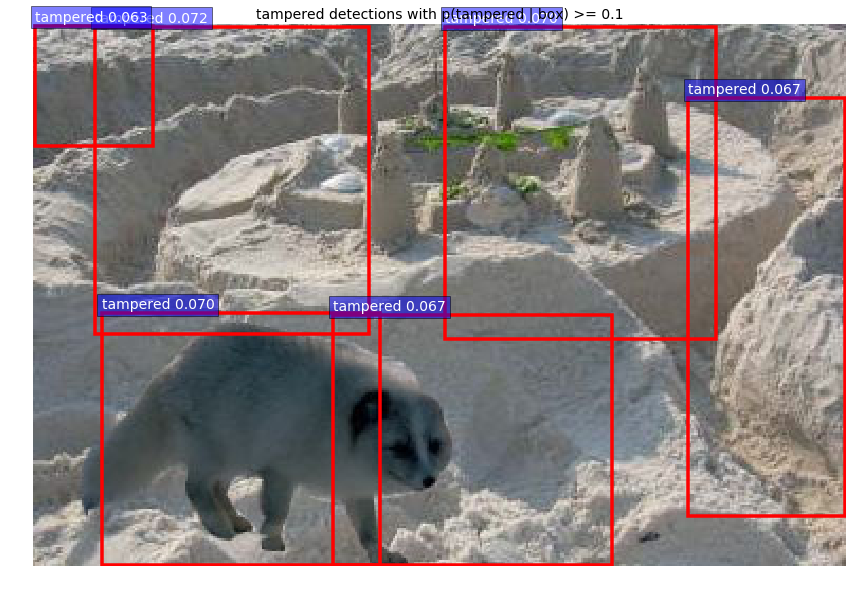

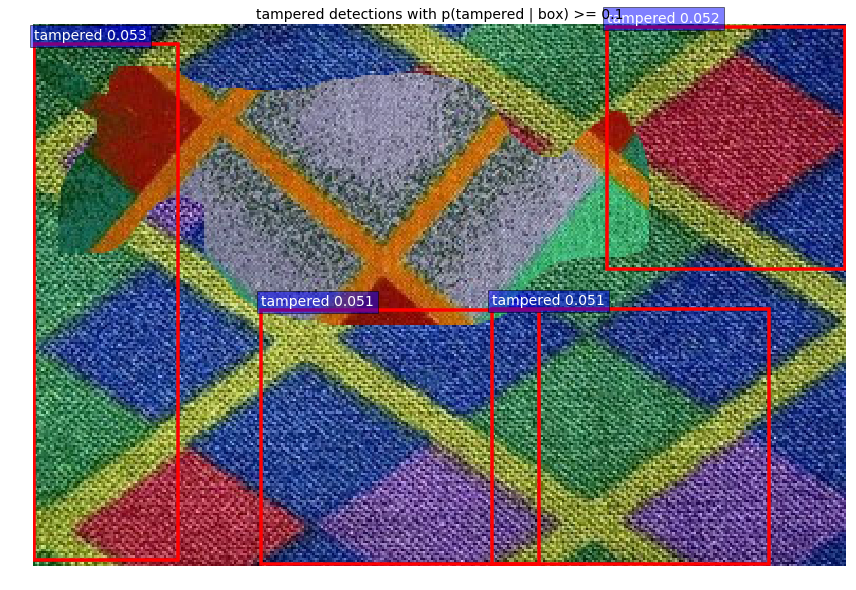

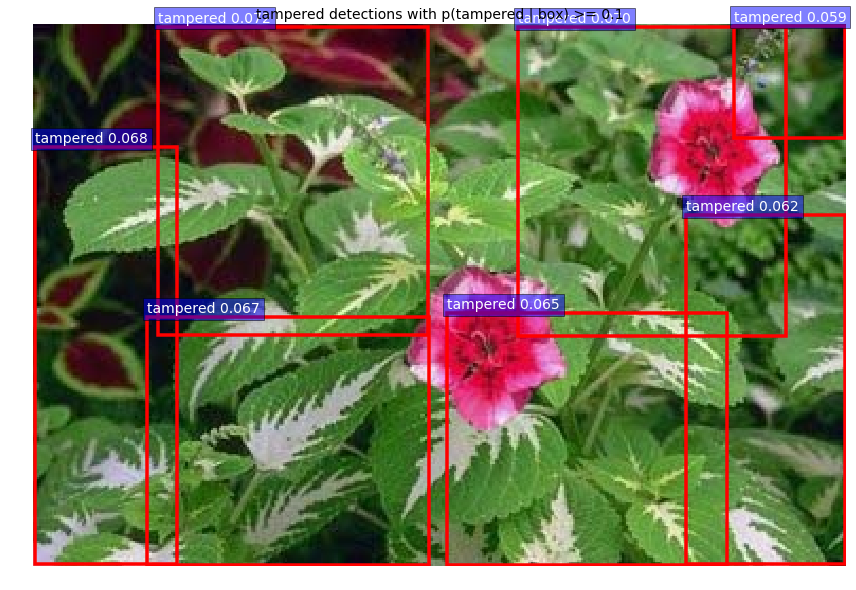

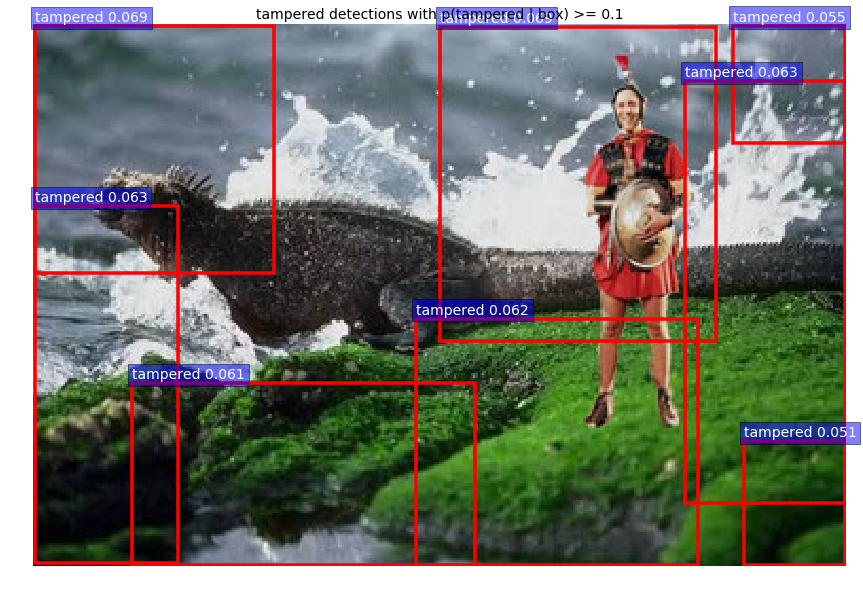

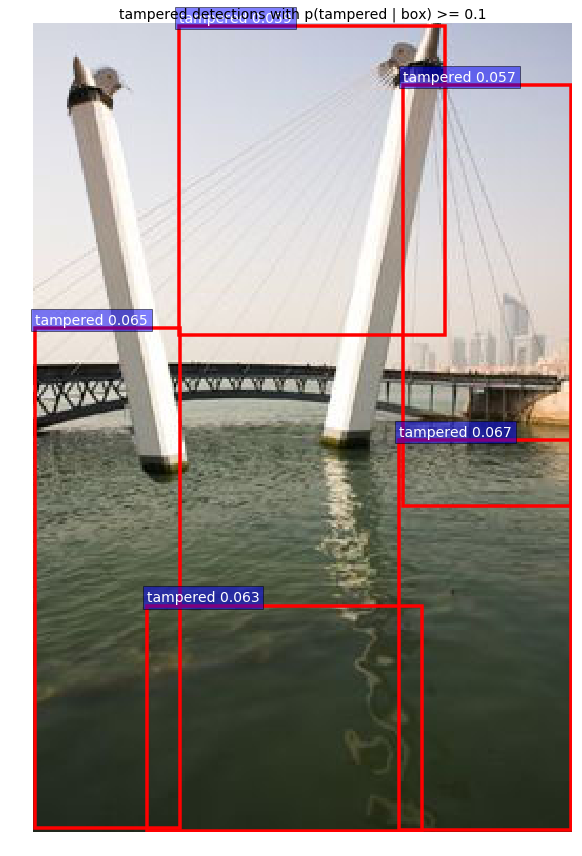

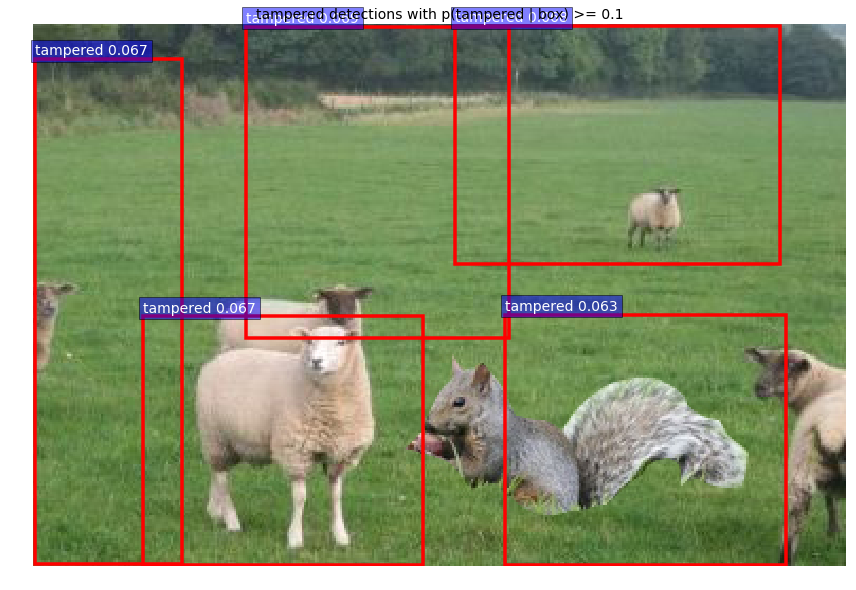

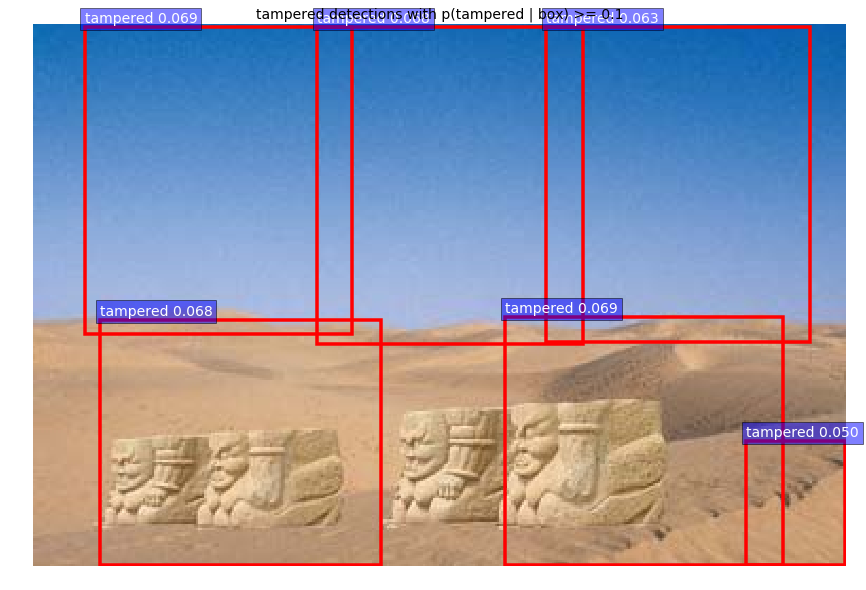

In [7]:
# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Hangyan Jiang, based on code from Ross Girshick
# --------------------------------------------------------


"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from lib.config import config as cfg
from lib.utils.nms_wrapper import nms
from lib.utils.test import im_detect
#from nets.resnet_v1 import resnetv1
from lib.nets.vgg16noise import vgg16
from lib.utils.timer import Timer
# tf.app.flags.DEFINE_string('f', '', 'kernel')
CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_noise_iter_400.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


tf.reset_default_graph()
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.05
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_noise_iter_500.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_noise_iter_500.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 1.663s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 1.601s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 1.612s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 1.627s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 1.579s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_042

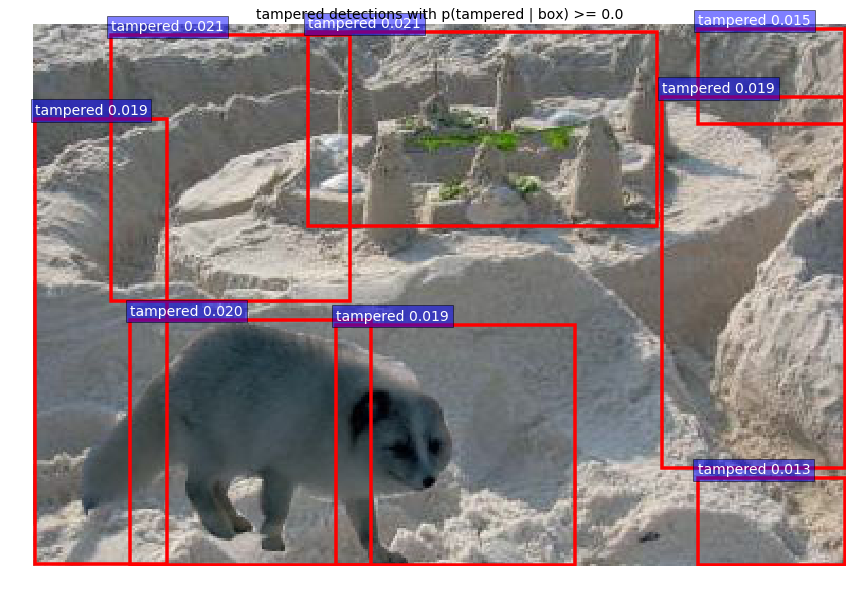

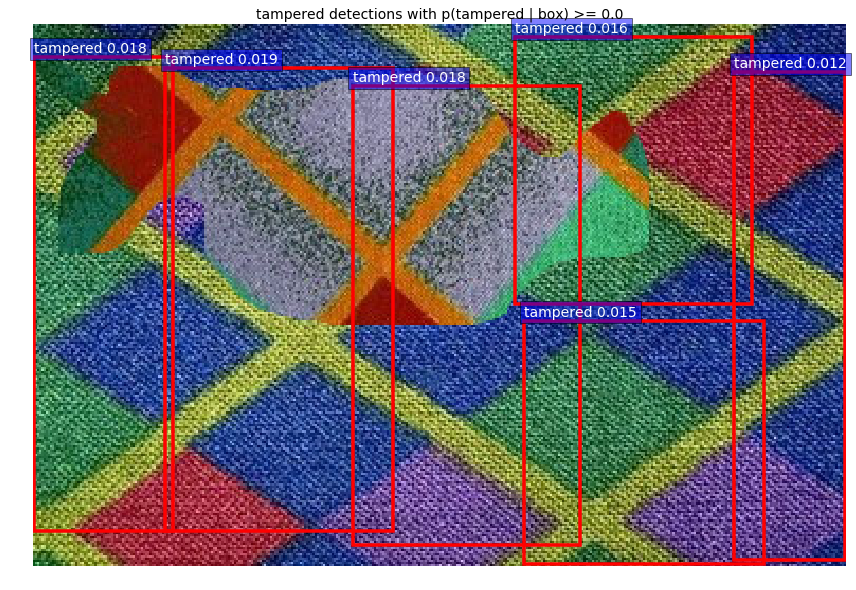

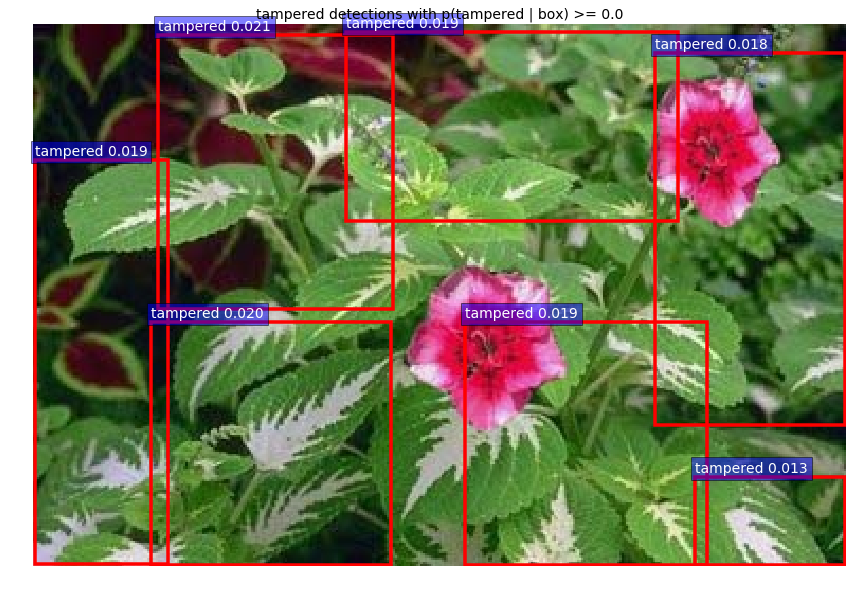

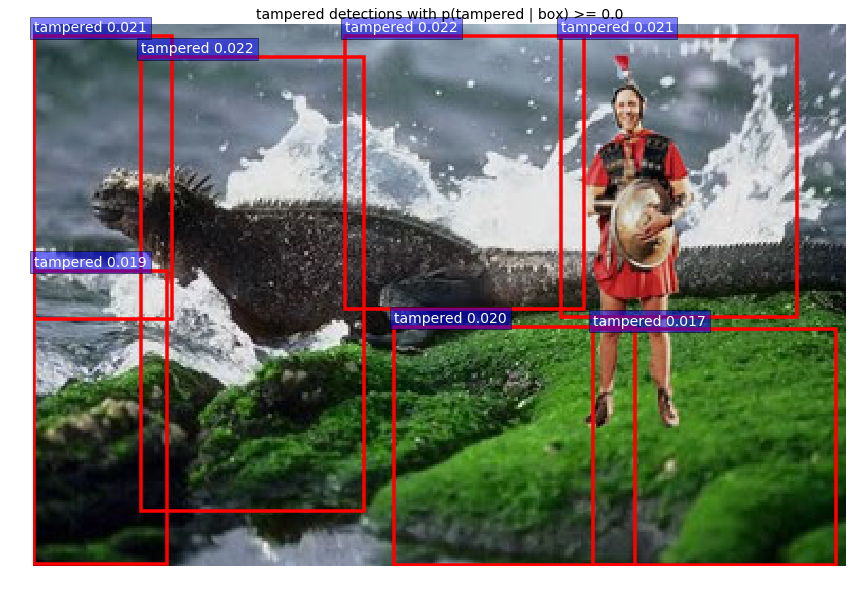

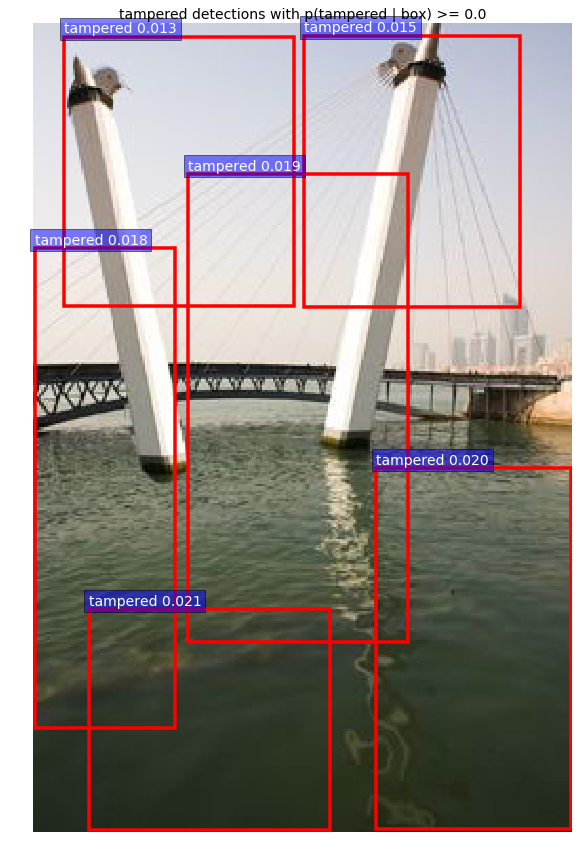

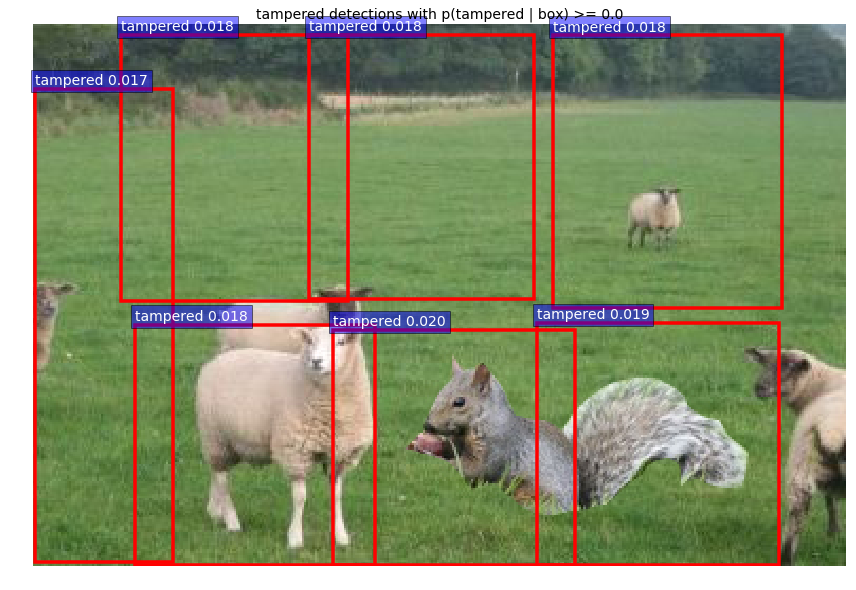

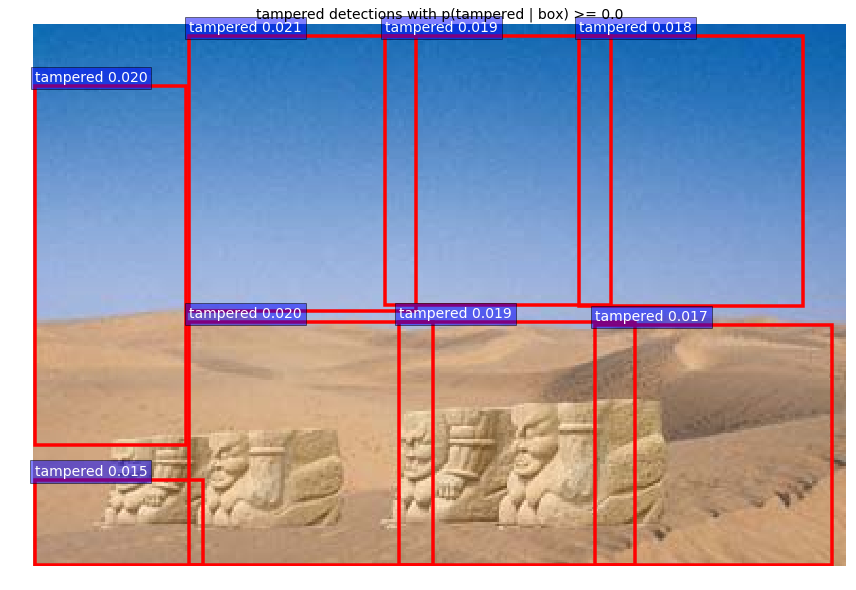

In [12]:

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_noise_iter_500.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


tf.reset_default_graph()
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.01
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

In [11]:

CLASSES = ('__background__',
           'tampered')

# PLEASE specify weight files dir for vgg16
NETS = {'vgg16': ('vgg16_faster_rcnn_noise_iter_1000.ckpt',), 'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS = {'pascal_voc': ('voc_2007_trainval',), 'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


tf.reset_default_graph()
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join('lib/layer_utils', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.05
    NMS_THRESH = 0.1

    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)


def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='vgg16')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args(args=[])

    return args


if __name__ == '__main__':
    args = parse_args()

    # model path
    demonet = args.demo_net
    dataset = args.dataset
    tfmodel = os.path.join('default', 'DIY_dataset', 'default', NETS[demonet][0])

    if not os.path.isfile(tfmodel + '.meta'):
        print(tfmodel)
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(tfmodel + '.meta'))

    # set config
    tfconfig = tf.ConfigProto(allow_soft_placement=True)
    tfconfig.gpu_options.allow_growth = True

    # init session
    sess = tf.Session(config=tfconfig)
    # load network
    if demonet == 'vgg16':
        net = vgg16(batch_size=1)
    # elif demonet == 'res101':
        # net = resnetv1(batch_size=1, num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(sess, "TEST", 2,
                            tag='default', anchor_scales=[8, 16, 32])
    saver = tf.train.Saver()
    saver.restore(sess, tfmodel)

    print('Loaded network {:s}'.format(tfmodel))

    for file in os.listdir("./lib/layer_utils"):
        if file.endswith(".jpg"):
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('Demo for lib/layer_utils/{}'.format(file))
            demo(sess, net, file)

    plt.show()

INFO:tensorflow:Restoring parameters from default/DIY_dataset/default/vgg16_faster_rcnn_noise_iter_1000.ckpt
Loaded network default/DIY_dataset/default/vgg16_faster_rcnn_noise_iter_1000.ckpt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_sec0083_ani0039_0401.jpg
Detection took 1.754s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_A_txt0062_txt0060_0149.jpg
Detection took 1.597s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_CRN_A_pla0006_pla0009_0391.jpg
Detection took 1.589s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0056_cha0062_0437.jpg
Detection took 1.608s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NNN_R_arc0088_arc0088_0367.jpg
Detection took 1.606s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for lib/layer_utils/Sp_D_NRN_A_ani0082_ani0097_0